In [1]:
## import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import pyspark.sql.functions as f
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
# Import all functions from pyspark.sql.functions, including col etc to manipulate columns
from pyspark.sql.functions import *
# Vector Assembler
from pyspark.ml.feature import VectorAssembler
# Standardisation
from pyspark.ml.feature import StandardScaler
# StringIndexer
from pyspark.ml.feature import *
# RegressionEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
# Gradient Boost Tree Regression Analysis
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorIndexer

In [2]:
!hdfs dfs -put /home/master/Downloads/LC

In [3]:
!hdfs dfs -ls LC

Found 4 items
-rw-r--r--   1 master supergroup   48669611 2019-02-15 19:28 LC/LoanStats_2017Q1.csv
-rw-r--r--   1 master supergroup   53047611 2019-02-15 19:28 LC/LoanStats_2017Q2.csv
-rw-r--r--   1 master supergroup   61960082 2019-02-15 19:28 LC/LoanStats_2017Q3.csv
-rw-r--r--   1 master supergroup   59676775 2019-02-15 19:28 LC/LoanStats_2017Q4.csv


In [2]:
loans = spark.read.format("com.databricks.spark.csv")\
.option("header", "true")\
.option("inferSchema", "true").\
load(["hdfs://localhost:8020/user/master/LC/LoanStats_2017Q1.csv",
     "hdfs://localhost:8020/user/master/LC/LoanStats_2017Q2.csv",
     "hdfs://localhost:8020/user/master/LC/LoanStats_2017Q3.csv",
     "hdfs://localhost:8020/user/master/LC/LoanStats_2017Q4.csv"])

In [3]:
# type
type(loans)

pyspark.sql.dataframe.DataFrame

In [3]:
loans.count()

443080

In [6]:
# in-memory-usage
loans.cache()

DataFrame[id: string, member_id: string, loan_amnt: string, funded_amnt: string, funded_amnt_inv: string, term: string, int_rate: string, installment: string, grade: string, sub_grade: string, emp_title: string, emp_length: string, home_ownership: string, annual_inc: string, verification_status: string, issue_d: string, loan_status: string, pymnt_plan: string, url: string, desc: string, purpose: string, title: string, zip_code: string, addr_state: string, dti: string, delinq_2yrs: string, earliest_cr_line: string, inq_last_6mths: string, mths_since_last_delinq: string, mths_since_last_record: string, open_acc: string, pub_rec: string, revol_bal: string, revol_util: string, total_acc: string, initial_list_status: string, out_prncp: string, out_prncp_inv: string, total_pymnt: string, total_pymnt_inv: string, total_rec_prncp: string, total_rec_int: string, total_rec_late_fee: string, recoveries: string, collection_recovery_fee: string, last_pymnt_d: string, last_pymnt_amnt: string, next_p

In [3]:
loans.createOrReplaceTempView("loans")

In [8]:
spark.sql("SELECT * FROM loans LIMIT 1").show(n=1)

+----+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------+----------+--------------+----------+-------------------+--------+-----------+----------+----+----+------------------+------------------+--------+----------+----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+----------------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+---

In [21]:
spark.sql("SELECT * FROM loans LIMIT 5").toPandas().head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term;,_c145,_c146,_c147
0,None,None,16000,16000,16000,60,12.74,361.93,C,C1,...,N,None,None,None,None,None,;,None,None,None
1,None,None,11875,11875,11875,36,11.44,391.26,B,B4,...,N,None,None,None,None,None,;,None,None,None
2,None,None,12000,12000,12000,36,7.99,375.99,A,A5,...,N,None,None,None,None,None,;,None,None,None
3,None,None,25000,25000,25000,36,15.99,878.81,C,C5,...,N,None,None,None,None,None,;,None,None,None
4,None,None,1500,1500,1500,36,5.32,45.18,A,A1,...,N,None,None,None,None,None,;,None,None,None


In [4]:
loans_a = loans['int_rate','loan_amnt','term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc','verification_status','purpose','addr_state', 'open_acc']

In [5]:
loans_a = loans_a.withColumn("loan_amnt", loans_a["loan_amnt"].cast(IntegerType()))
loans_a = loans_a.withColumn("term", loans_a["term"].cast(IntegerType()))
loans_a = loans_a.withColumn("emp_length", loans_a["emp_length"].cast(IntegerType()))
loans_a = loans_a.withColumn("annual_inc", loans_a["annual_inc"].cast(IntegerType()))
loans_a = loans_a.withColumn("open_acc", loans_a["open_acc"].cast(IntegerType()))
loans_a = loans_a.withColumn("int_rate", loans_a["int_rate"].cast(IntegerType()))

In [11]:
loans_a.toPandas().head(5)

,int_rate,loan_amnt,term,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,open_acc
0,20,2800,36,D,D4,0,MORTGAGE,1,Not Verified,debt_consolidation,PA,13
1,10,11000,36,B,B4,0,MORTGAGE,1,Not Verified,debt_consolidation,FL,14
2,24,19200,60,E,E3,0,MORTGAGE,1,Not Verified,debt_consolidation,IN,11
3,19,25000,60,D,D3,0,MORTGAGE,1,Not Verified,debt_consolidation,PA,13
4,7,20000,36,A,A4,0,RENT,1,Not Verified,debt_consolidation,NY,8


In [12]:
loans_a.printSchema()

root
 |-- int_rate: integer (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- term: integer (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_length: integer (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: integer (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- open_acc: integer (nullable = true)



In [13]:
#missing value analysis
loans_a_pd = loans_a.toPandas()
loans_a_pd.isnull().sum()

int_rate               0
loan_amnt              0
term                   0
grade                  0
sub_grade              0
emp_length             0
home_ownership         0
annual_inc             0
verification_status    0
purpose                0
addr_state             0
open_acc               0
dtype: int64

In [14]:
# descriptive stats on the data
loans_a.describe().toPandas()

,summary,int_rate,loan_amnt,term,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,open_acc
0,count,443080,443080,443080,443080,443080,443080,443080,443080,443080,443080,443080,443080
1,mean,12.718466191207005,14841.138676988354,42.66050374650176,None,None,5.483576329331046,None,80194.4396610093,None,None,None,11.62047937167103
2,stddev,5.203642966740987,9630.427292613873,10.746629258128982,None,None,3.8227612307124237,None,204202.90394065322,None,None,None,5.789256580291201
3,min,5,1000,36,A,A1,0,ANY,0,Not Verified,car,AK,0
4,max,30,40000,60,G,G5,10,RENT,110000000,Verified,wedding,WY,93


In [6]:
# Transform and add to df
loans_a = loans_a.withColumn('loan_amnt_tsd', col('loan_amnt')/1000)
loans_a = loans_a.withColumn('annual_inc_tsd', col('annual_inc')/1000)

In [7]:
# z-Standardisation
loans_a = loans_a.withColumn('loan_amnt_zstand', (col('loan_amnt')-14841.13)/9630.42)
loans_a = loans_a.withColumn('annual_inc_zstand', (col('annual_inc')-80194.43)/204202.90)

In [8]:
loans_a.printSchema()

root
 |-- int_rate: integer (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- term: integer (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_length: integer (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: integer (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- open_acc: integer (nullable = true)
 |-- loan_amnt_tsd: double (nullable = true)
 |-- annual_inc_tsd: double (nullable = true)
 |-- loan_amnt_zstand: double (nullable = true)
 |-- annual_inc_zstand: double (nullable = true)



In [9]:
# TempView
loans_a.createOrReplaceTempView("loans_a")

In [10]:
loans_b = spark.sql("SELECT int_rate, LOG(loan_amnt_tsd) AS loan_amnt_ln, LOG(annual_inc_tsd) AS annual_inc_ln, \
                       emp_length, grade, sub_grade, home_ownership, verification_status, purpose, addr_state, \
                       open_acc, term FROM loans_a")

In [11]:
loans_b.cache()

DataFrame[int_rate: int, loan_amnt_ln: double, annual_inc_ln: double, emp_length: int, grade: string, sub_grade: string, home_ownership: string, verification_status: string, purpose: string, addr_state: string, open_acc: int, term: int]

In [12]:
loans_b.createOrReplaceTempView("loans_b")

In [28]:
loans_b.toPandas().head(3)

,int_rate,loan_amnt_ln,annual_inc_ln,emp_length,grade,sub_grade,home_ownership,verification_status,purpose,addr_state,open_acc,term
0,20,1.029619,-6.907755,0,D,D4,MORTGAGE,Not Verified,debt_consolidation,PA,13,36
1,10,2.397895,-6.907755,0,B,B4,MORTGAGE,Not Verified,debt_consolidation,FL,14,36
2,24,2.954910,-6.907755,0,E,E3,MORTGAGE,Not Verified,debt_consolidation,IN,11,60


In [13]:
stringIndexer = StringIndexer(inputCol='home_ownership', outputCol='home_ownership_num')
model = stringIndexer.fit(loans_b)
loans_b = model.transform(loans_b)

stringIndexer = StringIndexer(inputCol='verification_status', outputCol='verification_status_num')
model = stringIndexer.fit(loans_b)
loans_b = model.transform(loans_b)

stringIndexer = StringIndexer(inputCol='addr_state', outputCol='addr_state_num')
model = stringIndexer.fit(loans_b)
loans_b = model.transform(loans_b)

stringIndexer = StringIndexer(inputCol='purpose', outputCol='purpose_num')
model = stringIndexer.fit(loans_b)
loans_b = model.transform(loans_b)

stringIndexer = StringIndexer(inputCol='grade', outputCol='grade_num')
model = stringIndexer.fit(loans_b)
loans_b = model.transform(loans_b)

# #SUB_GRADE REMOVED FROM MODELING DUE TO SYSTEM CRASH
#stringIndexer = StringIndexer(inputCol='sub_grade', outputCol='sub_grade_num')
#model = stringIndexer.fit(loans_b)
#loans_b = model.transform(loans_b)

#loans_b.toPandas().head(5)

In [14]:
# setup OneHotEncoder
encoder = OneHotEncoder(inputCol='home_ownership_num', outputCol='home_ownership_cat') # dropLast = False
# apply to data
loans_b = encoder.transform(loans_b)


encoder = OneHotEncoder(inputCol='verification_status_num', outputCol='verification_status_cat') # dropLast = False
loans_b = encoder.transform(loans_b)


encoder = OneHotEncoder(inputCol='addr_state_num', outputCol='addr_state_cat') # dropLast = False
loans_b = encoder.transform(loans_b)

encoder = OneHotEncoder(inputCol='purpose_num', outputCol='purpose_cat') # dropLast = False
loans_b = encoder.transform(loans_b)

encoder = OneHotEncoder(inputCol='grade_num', outputCol='grade_cat') # dropLast = False
loans_b = encoder.transform(loans_b)

# #SUB_GRADE REMOVED FROM MODELING DUE TO SYSTEM CRASH
#encoder = OneHotEncoder(inputCol='sub_grade_num', outputCol='sub_grade_cat') # dropLast = False
#loans_b = encoder.transform(loans_b)

#loans_b.toPandas().head(5)

In [15]:
# Initalize
vectorAssembler = VectorAssembler(inputCols = ['loan_amnt_ln','term', 'addr_state_cat', 'grade_cat', 'emp_length', \
                                               'home_ownership_cat', 'annual_inc_ln','verification_status_cat', \
                                               'purpose_cat', 'open_acc'], 
                                  outputCol = 'features')
loans_b_ml = vectorAssembler.setHandleInvalid("skip").transform(loans_b)
loans_b_ml.printSchema()

root
 |-- int_rate: integer (nullable = true)
 |-- loan_amnt_ln: double (nullable = true)
 |-- annual_inc_ln: double (nullable = true)
 |-- emp_length: integer (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- open_acc: integer (nullable = true)
 |-- term: integer (nullable = true)
 |-- home_ownership_num: double (nullable = false)
 |-- verification_status_num: double (nullable = false)
 |-- addr_state_num: double (nullable = false)
 |-- purpose_num: double (nullable = false)
 |-- grade_num: double (nullable = false)
 |-- home_ownership_cat: vector (nullable = true)
 |-- verification_status_cat: vector (nullable = true)
 |-- addr_state_cat: vector (nullable = true)
 |-- purpose_cat: vector (nullable = true)
 |-- grade_cat: vector (nullable = true)
 |-- features

In [16]:
loans_b_mll = loans_b_ml.select('features','int_rate')

In [15]:
loans_b_mll.toPandas().head(5)

,features,int_rate
0,"(1.0296194171811581, 36.0, 0.0, 0.0, 0.0, 1.0,...",20
1,"(2.3978952727983707, 36.0, 0.0, 1.0, 0.0, 0.0,...",10
2,"(2.954910279033736, 60.0, 0.0, 0.0, 0.0, 0.0, ...",24
3,"(3.2188758248682006, 60.0, 0.0, 0.0, 0.0, 1.0,...",19
4,"(2.995732273553991, 36.0, 0.0, 0.0, 1.0, 0.0, ...",7


In [17]:
training_data, test_data = loans_b_mll.randomSplit(weights=[.7,.3], seed=25)

In [18]:
training_data.count()

310071

In [19]:
test_data.count()

133008

In [18]:
#Step 1: Initialize the GBT regressor
gbt_cat = GBTRegressor(labelCol="int_rate", 
                          maxIter=100, 
                          featuresCol='features')

In [19]:
gbtModel_cat = gbt_cat.fit(training_data)

In [20]:
# coefficients/feature importance
gbtModel_cat.featureImportances

SparseVector(79, {0: 0.1433, 1: 0.0446, 2: 0.0053, 3: 0.0031, 4: 0.0071, 5: 0.0034, 6: 0.0054, 7: 0.0007, 8: 0.004, 9: 0.0024, 10: 0.0064, 11: 0.0029, 12: 0.0059, 13: 0.0047, 14: 0.0061, 15: 0.0035, 16: 0.001, 17: 0.0027, 18: 0.003, 19: 0.0051, 20: 0.0029, 21: 0.0034, 22: 0.0025, 23: 0.0034, 24: 0.002, 25: 0.0041, 26: 0.0033, 27: 0.0053, 28: 0.0026, 29: 0.0028, 30: 0.0034, 31: 0.0033, 32: 0.005, 33: 0.0017, 34: 0.0099, 35: 0.0012, 36: 0.0007, 37: 0.002, 38: 0.0017, 39: 0.0044, 40: 0.0032, 41: 0.0032, 42: 0.004, 43: 0.001, 44: 0.0037, 45: 0.0029, 46: 0.0015, 47: 0.0028, 48: 0.002, 49: 0.001, 50: 0.0022, 51: 0.0298, 52: 0.0275, 53: 0.0135, 54: 0.0329, 55: 0.0413, 56: 0.015, 57: 0.0461, 58: 0.0169, 59: 0.0085, 60: 0.0043, 61: 0.005, 62: 0.1467, 63: 0.0165, 64: 0.0248, 65: 0.0084, 66: 0.0186, 67: 0.009, 68: 0.0119, 69: 0.0056, 70: 0.0068, 71: 0.0088, 72: 0.0066, 73: 0.004, 74: 0.0078, 75: 0.0058, 76: 0.0032, 77: 0.0017, 78: 0.1197})

In [21]:
gbtModel_cat.trees

[DecisionTreeRegressionModel (uid=dtr_b2c2aa8d74ac) of depth 5 with 63 nodes,
 DecisionTreeRegressionModel (uid=dtr_1315242b5471) of depth 5 with 63 nodes,
 DecisionTreeRegressionModel (uid=dtr_c8fe42686756) of depth 5 with 63 nodes,
 DecisionTreeRegressionModel (uid=dtr_d5ee56c61114) of depth 5 with 63 nodes,
 DecisionTreeRegressionModel (uid=dtr_7dfed93c4080) of depth 5 with 63 nodes,
 DecisionTreeRegressionModel (uid=dtr_047bdb30add6) of depth 5 with 61 nodes,
 DecisionTreeRegressionModel (uid=dtr_bf6e3e7607de) of depth 5 with 63 nodes,
 DecisionTreeRegressionModel (uid=dtr_13444d26ebd5) of depth 5 with 63 nodes,
 DecisionTreeRegressionModel (uid=dtr_644c1472ec92) of depth 5 with 61 nodes,
 DecisionTreeRegressionModel (uid=dtr_2200303c70d8) of depth 5 with 63 nodes,
 DecisionTreeRegressionModel (uid=dtr_7319885eab6f) of depth 5 with 63 nodes,
 DecisionTreeRegressionModel (uid=dtr_b431572eb30a) of depth 5 with 53 nodes,
 DecisionTreeRegressionModel (uid=dtr_a370bb5828fd) of depth 5 w

In [22]:
predictions_gbt = gbtModel_cat.transform(test_data)
predictions_gbt.printSchema()

root
 |-- features: vector (nullable = true)
 |-- int_rate: integer (nullable = true)
 |-- prediction: double (nullable = false)



In [23]:
predictions_gbt.toPandas().head(50)

,features,int_rate,prediction
0,"(1.2809338454620642, 36.0, 1.0, 0.0, 0.0, 0.0,...",15,13.652326
1,"(1.4929040961781488, 36.0, 1.0, 0.0, 0.0, 0.0,...",16,13.672138
2,"(1.6094379124341003, 36.0, 1.0, 0.0, 0.0, 0.0,...",13,13.566593
3,"(1.6094379124341003, 36.0, 1.0, 0.0, 0.0, 0.0,...",13,13.567766
4,"(1.6094379124341003, 36.0, 1.0, 0.0, 0.0, 0.0,...",16,13.802416
5,"(1.6094379124341003, 36.0, 1.0, 0.0, 0.0, 0.0,...",16,13.614341
6,"(1.9740810260220096, 36.0, 1.0, 0.0, 0.0, 0.0,...",12,13.697985
7,"(2.0794415416798357, 36.0, 1.0, 0.0, 0.0, 0.0,...",14,13.534152
8,"(2.302585092994046, 36.0, 1.0, 0.0, 0.0, 0.0, ...",16,13.658108
9,"(2.302585092994046, 36.0, 1.0, 0.0, 0.0, 0.0, ...",13,13.652059


In [28]:
# Calculate residuals
predictions_gbt = predictions_gbt.withColumn('residuals', (col('int_rate') - col('prediction')))
predictions_gbt.printSchema()

root
 |-- features: vector (nullable = true)
 |-- int_rate: integer (nullable = true)
 |-- prediction: double (nullable = false)
 |-- residuals: double (nullable = true)



In [29]:
predictions_gbt_pd = predictions_gbt.toPandas()
type(predictions_gbt_pd)

pandas.core.frame.DataFrame

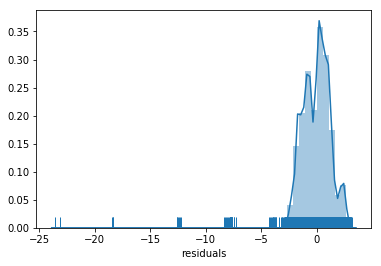

In [30]:
# plot the residuals
sns.distplot(a=predictions_gbt_pd['residuals'], rug = True)

In [24]:
evaluator = RegressionEvaluator(metricName="r2",labelCol='int_rate')

In [25]:
evaluator.evaluate(predictions_gbt)

0.9486629973545149